# Standardize ASCAD database

In [1]:
import os

import h5py
import numpy as np
import seaborn as sns
from matplotlib.pyplot import show
from numpy import logical_and as _and
from numpy.random import shuffle, normal, binomial
from tqdm import tqdm

from src.data.loaders import aisy
from src.data.preprocess.hw import full_states
from src.pollution.clock_jitter import clock_jitter
from src.pollution.random_delay import random_delay
from src.tools.lists import find
from src.tools.plotter import init_plots
from src.trace_set.database import Database
from src.trace_set.pollution import Pollution, PollutionType
from src.trace_set.set_hw import TraceSetHW
from src.tvla.tvla import Group

init_plots()

In [2]:
IN_FILE = h5py.File(aisy.aes.tvla_ttables, "r")
TRACES = np.array(IN_FILE['traces_group/traces'], dtype=np.int8)
TVLA_BYTE = IN_FILE['traces_group/metadata']['tvla_byte'].astype(bool)[:, 0]
PLAINTEXT = IN_FILE['traces_group/metadata']['plaintext'].astype(int)
CIPHERTEXT = IN_FILE['traces_group/metadata']['ciphertext'].astype(int)
KEY = IN_FILE['traces_group/metadata']['key'].astype(int)

In [3]:
DB = Database.aisy

In [4]:
TRACE_LEN = TRACES.shape[1]
SAMPLE_TRACE = TRACES[0][round(TRACE_LEN * .3333):round(TRACE_LEN * .6666)]

In [5]:
FULL_STATES = full_states(PLAINTEXT, KEY)

100%|██████████| 10000/10000 [00:02<00:00, 3622.65it/s]


In [6]:
LABEL_FIFTH = FULL_STATES[:, 4, 0]

Y = np.array(LABEL_FIFTH)

In [7]:
def get_windows(raw_traces, sample_trace):
    start_ix = find(raw_traces[0], sample_trace)

    win_size = len(sample_trace)
    window = np.array((start_ix, start_ix + win_size))

    window_margin = win_size

    # Window with context
    window_cxt = window + np.array((-window_margin, window_margin))

    # Return the window relative to the window context.
    rel_window = window - window_cxt[0]

    return rel_window, window_cxt

WINDOW, WINDOW_CXT = get_windows(TRACES, SAMPLE_TRACE)

WINDOW

array([ 7332, 14664])

In [8]:
def extract_traces(raw_traces, window_cxt):
    num_traces, _ = raw_traces.shape

    wa, wb = window_cxt
    win_size = wb - wa

    traces_cxt = np.zeros((num_traces, win_size), dtype=np.int8)
    for ix in tqdm(range(num_traces)):
        traces_cxt[ix] = raw_traces[ix, window_cxt[0]:window_cxt[1]]

    return traces_cxt

X_CXT = extract_traces(TRACES, WINDOW_CXT)

100%|██████████| 10000/10000 [00:00<00:00, 100882.33it/s]


In [9]:
X = X_CXT[:, WINDOW[0]:WINDOW[1]]

In [10]:
PROFILING_MASK = np.ones(len(Y), dtype=bool)
PROFILING_MASK[2::3] = 0

Y_PROF = Y[PROFILING_MASK]
Y_ATT = Y[~PROFILING_MASK]

X_PROF_CXT = X_CXT[PROFILING_MASK]
X_ATT_CXT = X_CXT[~PROFILING_MASK]

X_PROF_CXT.shape, Y_PROF.shape

((6667, 21996), (6667,))

In [17]:
X_PROF = X_PROF_CXT[:, WINDOW[0]:WINDOW[1]]
X_ATT = X_ATT_CXT[:, WINDOW[0]:WINDOW[1]]

TraceSetHW(Database.aisy_raw).create(
    X_PROF_CXT, Y_PROF, X_ATT_CXT, Y_ATT
)

In [12]:
def fixed_fixed(x:np.ndarray, hw: np.ndarray):
    leakage_bit = hw > 4
    drop_mask = hw != 4

    return x[drop_mask], leakage_bit[drop_mask]

def tvla_goodwill(x:np.ndarray, la_bits: np.ndarray, order: int):
    ix_shuffle = np.arange(len(x))
    shuffle(ix_shuffle)

    xs, ys = x[ix_shuffle], la_bits[ix_shuffle]

    num_traces = len(x)
    mask = np.zeros(num_traces)
    mask[:round(num_traces / 2)] = 1
    mask = mask.astype(bool)

    low1, low2 = xs[_and(mask, ~ys)], xs[_and(~mask, ~ys)]
    high1, high2 = xs[_and(mask, ys)], xs[_and(~mask, ys)]

    t1, p1 = Group(low1, order, True).t_test(Group(high1, order, True), order)
    t2, p2 = Group(low2, order, True).t_test(Group(high2, order, True), order)

    t = np.min((np.abs(t1), np.abs(t2)), axis=0)
    p = np.max((p1, p2), axis=0)

    return t, p

X2, Y2 = fixed_fixed(X, Y)
A, B = X2[~Y2], X2[Y2]

ORDER = 1
_, TVLA_P = Group(A, ORDER, True).t_test(Group(B, ORDER, True), ORDER)
_, GOODWILL_P = tvla_goodwill(X2, Y2, ORDER)

Computing Central Moments: 100%|██████████| 3/3 [00:00<00:00, 87.43it/s]


<ipython-input-13-7115292478c8>:4: UserWarning: Attempted to set non-positive top ylim on a log-scaled axis.
Invalid limit will be ignored.
  g.set(yscale="log",


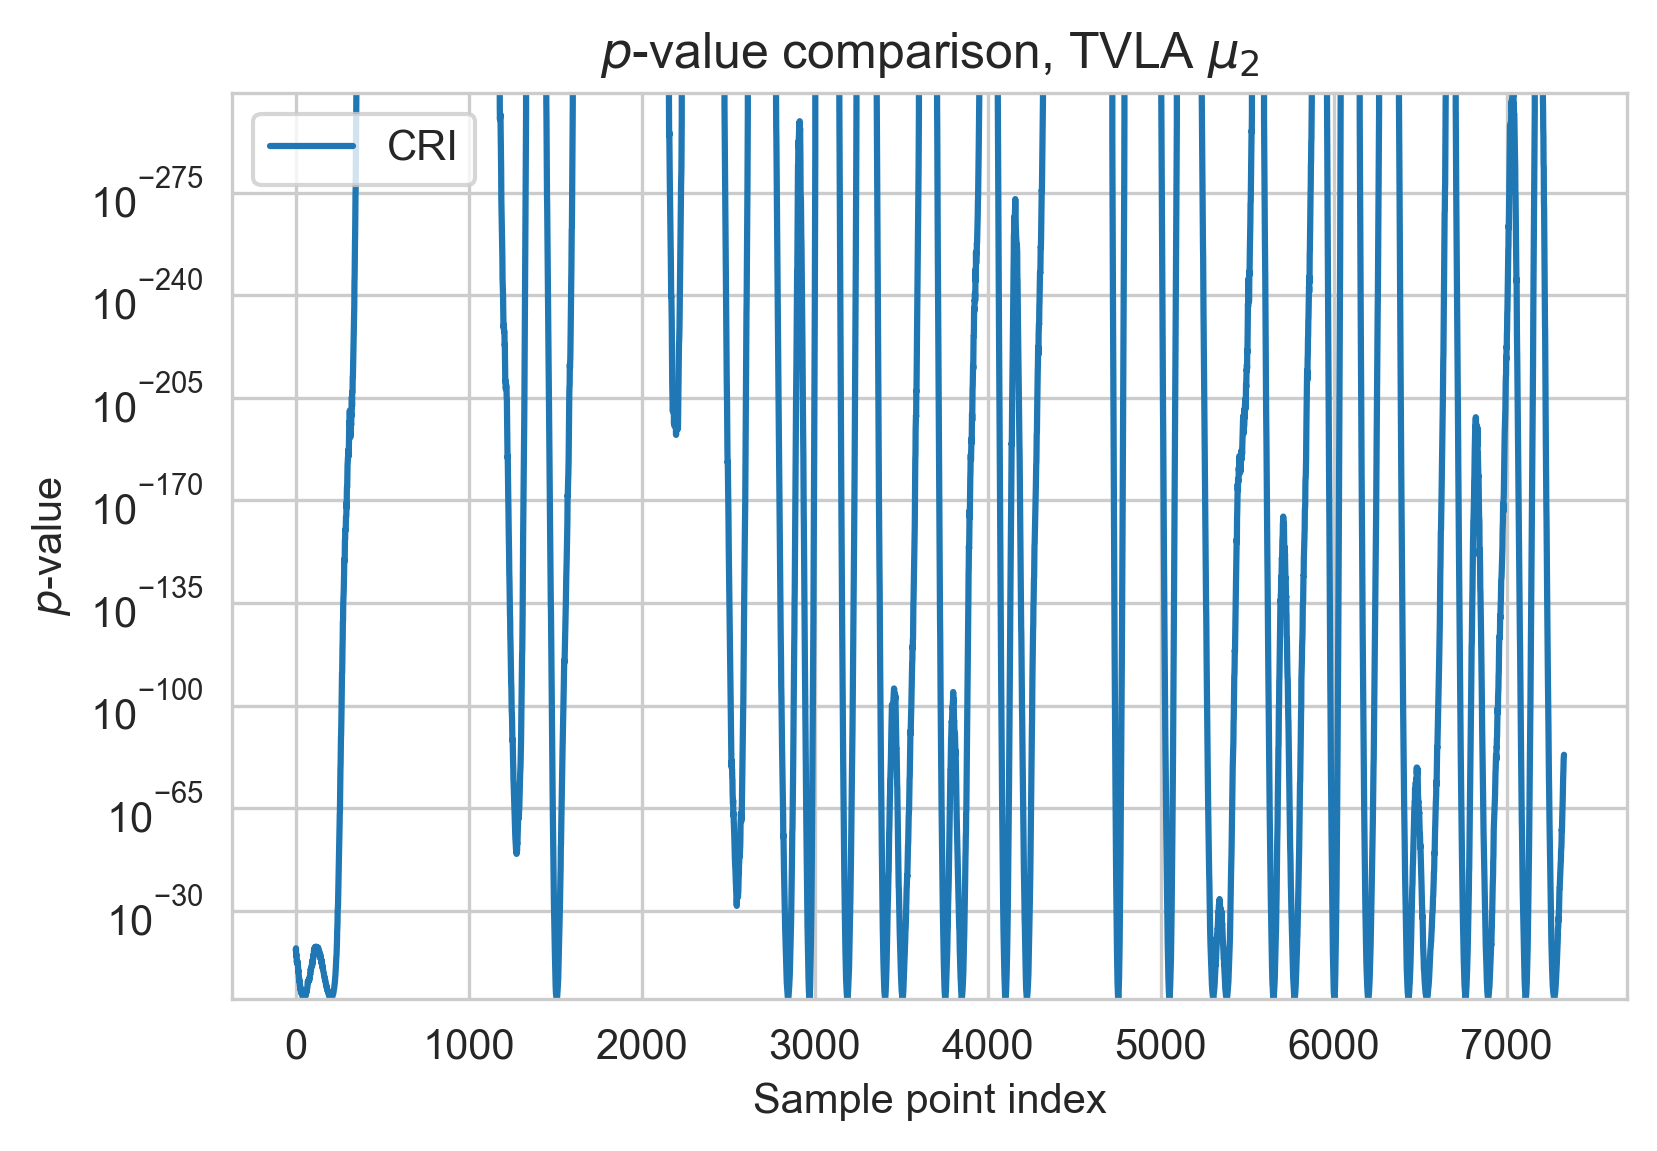

<ipython-input-13-7115292478c8>:4: UserWarning: Attempted to set non-positive top ylim on a log-scaled axis.
Invalid limit will be ignored.
  g.set(yscale="log",


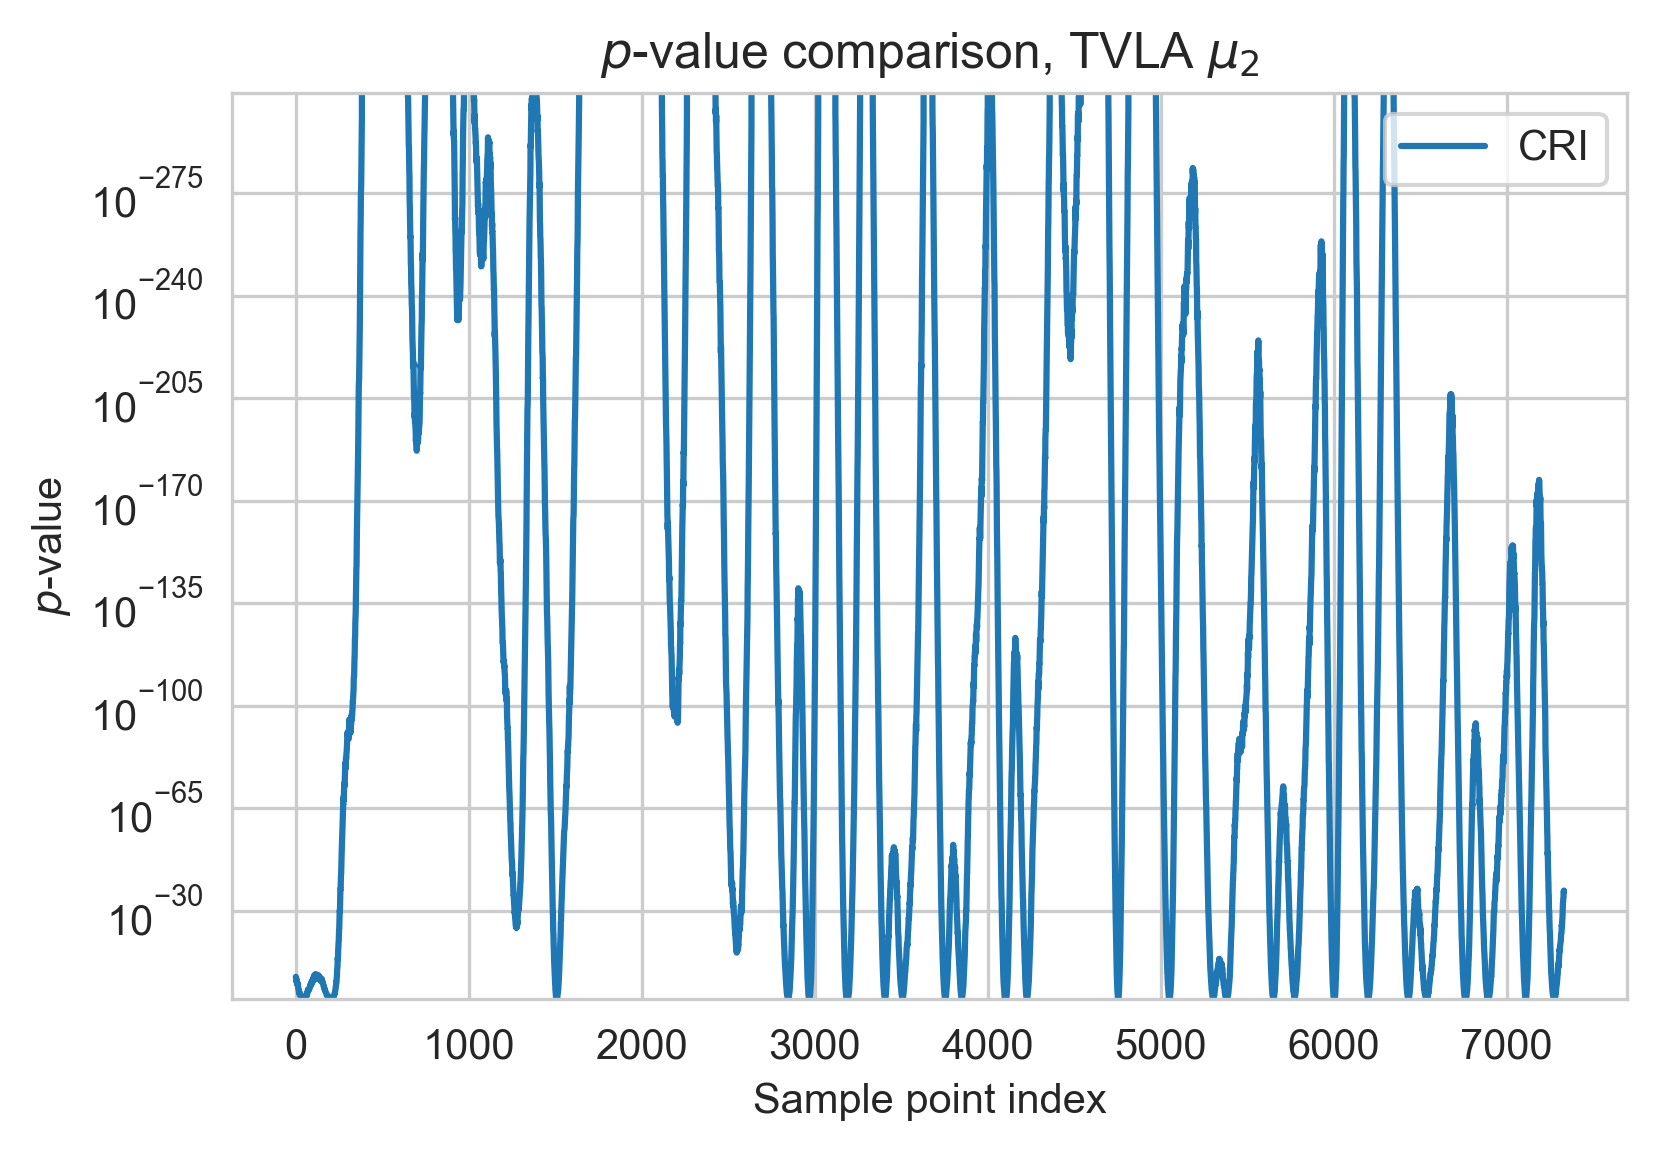

In [13]:
def plot_p(p_values):
    g = sns.lineplot(data={"CRI": p_values})
    g.invert_yaxis()
    g.set(yscale="log",
          title="$p$-value comparison, TVLA $\mu_2$",
          xlabel="Sample point index",
          ylabel="$p$-value", ylim=(1, 0))
    show(block=False)

plot_p(TVLA_P)
plot_p(GOODWILL_P)

In [14]:
SIM_NUM_SP = 100000
SIM_NUM_TRACES = 100
SIM_LABELS = binomial(1, .5, SIM_NUM_SP).astype(np.int8)
SIM_TRACES = np.array([normal(0, 2.2, SIM_NUM_TRACES)] * SIM_NUM_SP).astype(np.int8)
A, B = SIM_TRACES[~SIM_LABELS], SIM_TRACES[SIM_LABELS]

In [15]:
_, SIM_TVLA_P = Group(A, ORDER, True).t_test(Group(B, ORDER, True), ORDER)
_, SIM_GOODWILL_P = tvla_goodwill(SIM_TRACES, SIM_LABELS, ORDER)

Computing Central Moments: 100%|██████████| 3/3 [00:00<00:00, 55.05it/s]
/home/berg/Documents/Afstudeer/LA/src/tvla/t.py:22: RuntimeWarning: invalid value encountered in true_divide
  t = m / np.sqrt(sab)
Computing Central Moments: 100%|██████████| 3/3 [00:00<00:00, 268.91it/s]


<ipython-input-13-7115292478c8>:4: UserWarning: Attempted to set non-positive top ylim on a log-scaled axis.
Invalid limit will be ignored.
  g.set(yscale="log",


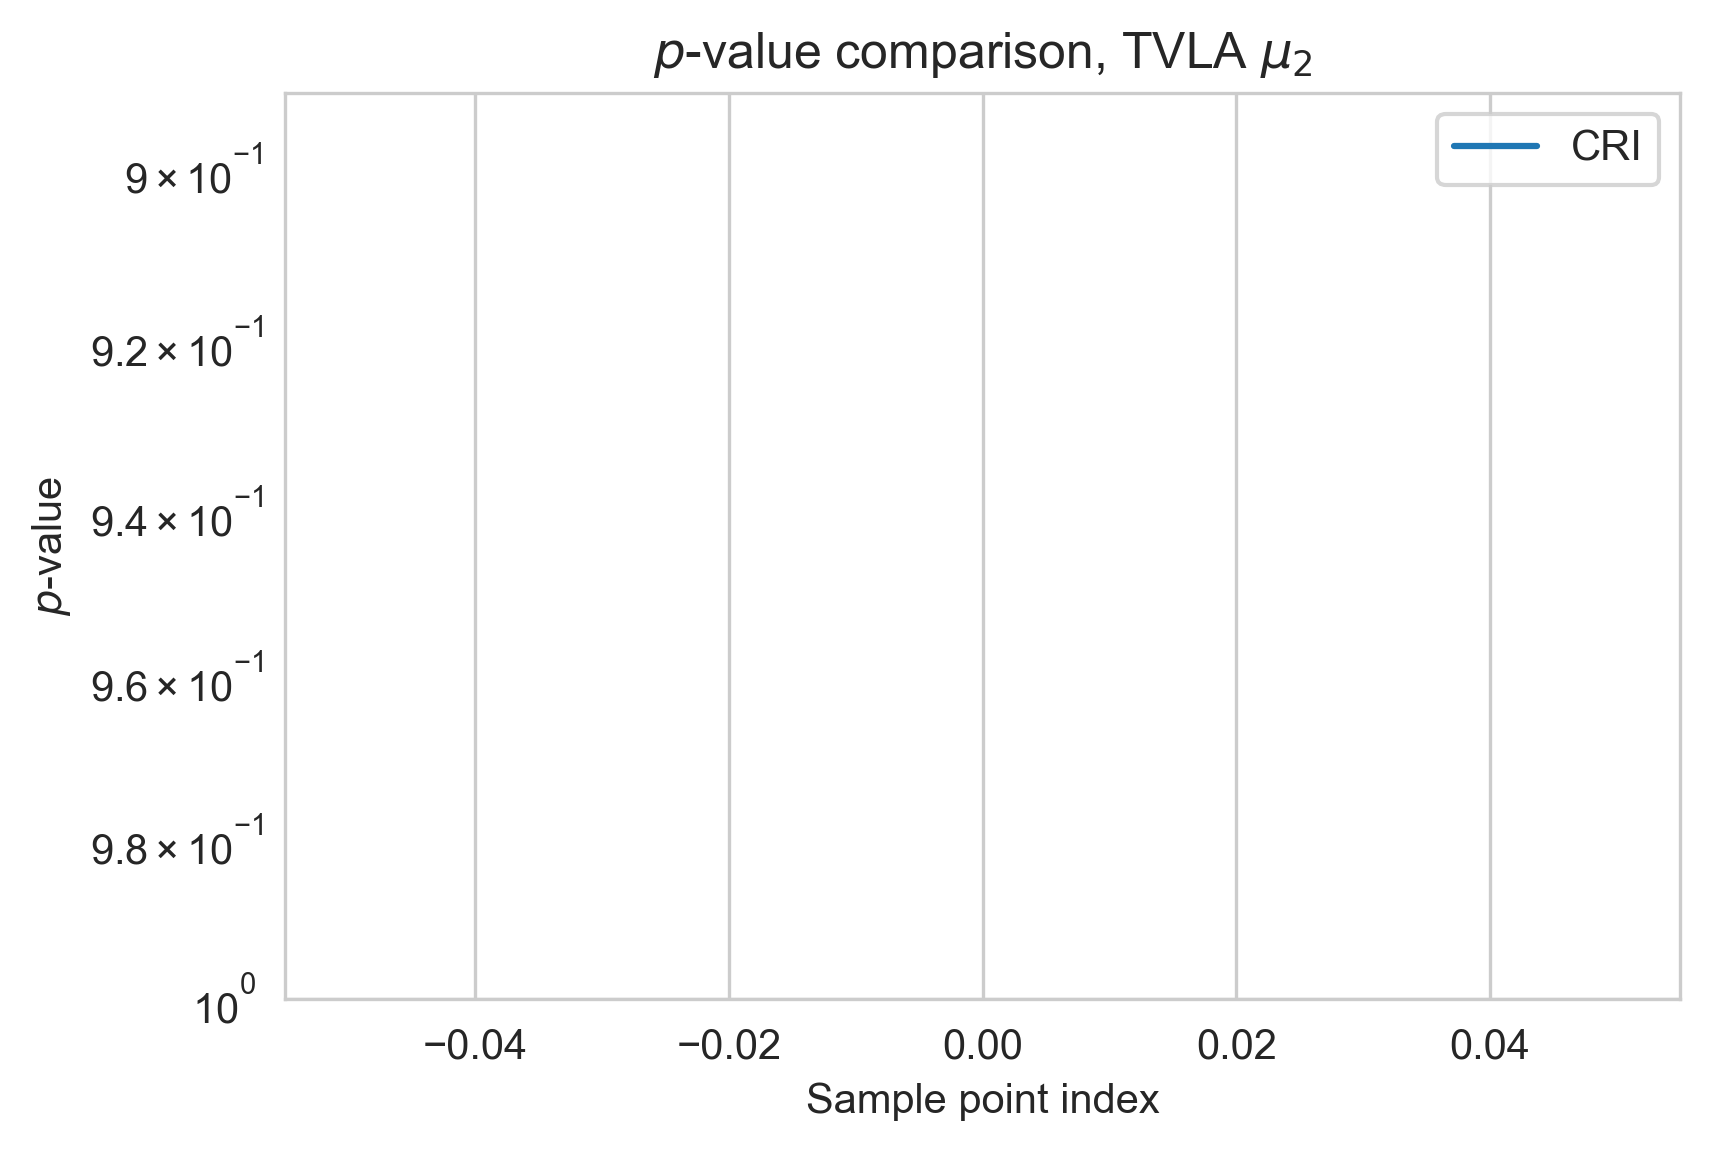

<ipython-input-13-7115292478c8>:4: UserWarning: Attempted to set non-positive top ylim on a log-scaled axis.
Invalid limit will be ignored.
  g.set(yscale="log",


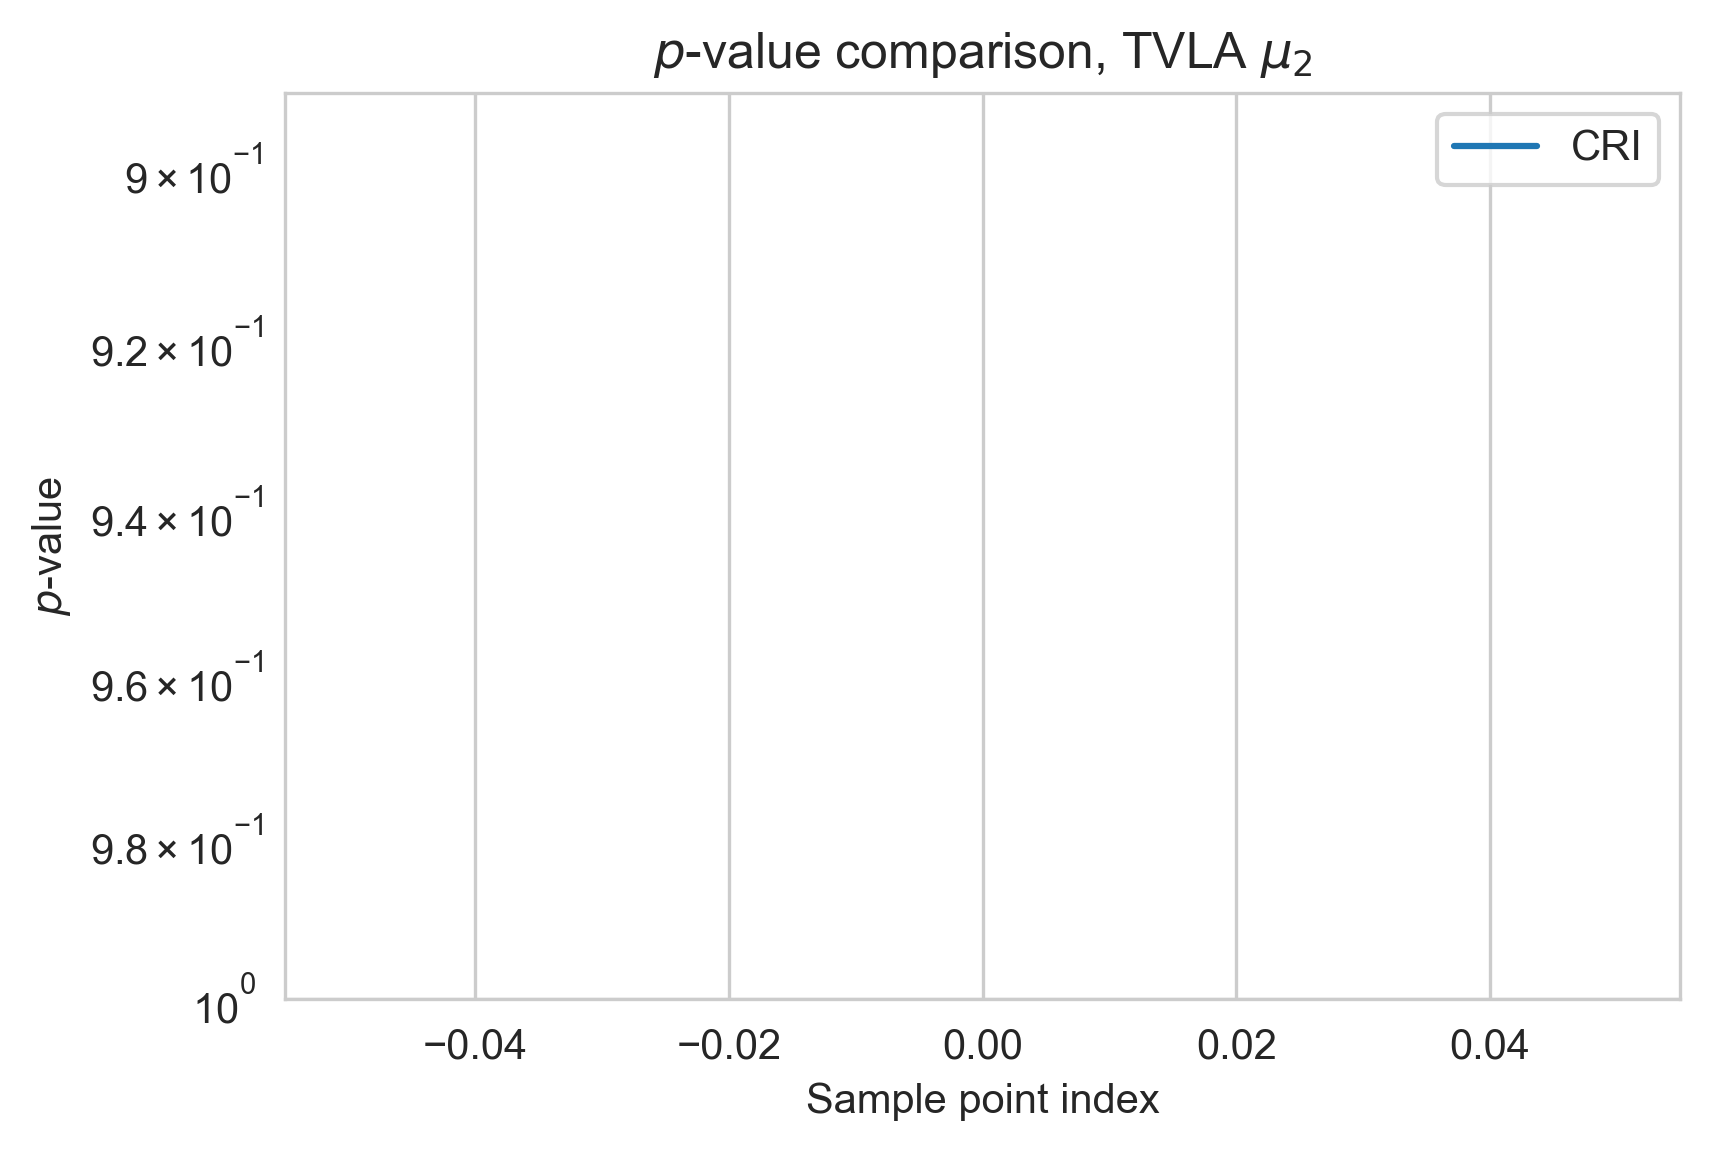

In [16]:
plot_p(SIM_TVLA_P)
plot_p(SIM_GOODWILL_P)